In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

% matplotlib inline

In [2]:
p_loc = 0.
p_scale = 1.
p = tf.distributions.Normal(loc=p_loc, scale=p_scale)

q_loc = 0.
q_scale = 1.
q = tf.distributions.Normal(loc=q_loc, scale=q_scale)

plot_points = np.linspace(-3., 8., 200)

# plt.plot(plot_points, sess.run(p.prob(plot_points)), 'b')
# plt.plot(plot_points, sess.run(q.prob(plot_points)), 'r')
# plt.show()

W0628 15:28:45.336045 4375299520 deprecation.py:323] From <ipython-input-2-c17ee52eb294>:3: __init__ (from tensorflow.python.ops.distributions.normal) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0628 15:28:45.359285 4375299520 deprecation.py:323] From /usr/local/lib/python2.7/site-packages/tensorflow/python/ops/distributions/normal.py:160: __init__ (from tensorflow.python.ops.distributions.distribution) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [56]:
tf.reset_default_graph()
tf.random.set_random_seed(42)

with tf.Session() as sess:

    p_loc = 0.
    p_scale = 1.
    p = tf.distributions.Normal(loc=p_loc, scale=p_scale)

    q_loc = 2.5
    q_scale = 0.5
    q = tf.distributions.Normal(loc=q_loc, scale=q_scale)

    n_points = 20
    
    p_mass = tf.concat(([0.], [1. / (n_points-2) for _ in range(n_points-2)], [0.]), axis=0)
    quantiles = np.linspace(0., 1., n_points+1)
    open_sections = q.quantile(quantiles[1:-1])

    p_i = tf.Variable(tf.zeros((n_points)))
    sess.run(tf.initialize_all_variables())
    p_star = tf.reduce_sum(p_i)
    
    open_cdf = p.cdf(open_sections)

    cdfs = tf.concat(([0.], open_cdf, [1.]), axis=0)
    probs = cdfs[1:] - cdfs[:-1] 
    
    alpha_i = tf.where(p_mass - p_i < (1 - p_star) * probs, p_mass - p_i, (1 - p_star) * probs)
    sample = p.sample()
    bucket = tf.concat((tf.reshape(tf.where(sample < open_sections),[-1]), [n_points-1]), axis=0)[0]
    beta = (alpha_i[bucket]) / ((1 - p_star) * probs[bucket])
    accept = (tf.random.uniform(()) < beta)
    update_op = [p_i.assign(p_i + alpha_i)]

    rejection_samples = []
    for i in tqdm(range(100)):
        sess.run(tf.initialize_all_variables())
        accepted = False
        s = 0.
        j = 0
        while not accepted:
            accepted, s = sess.run([accept, sample])
            sess.run(update_op)
            j += 1

        rejection_samples.append(s)
    

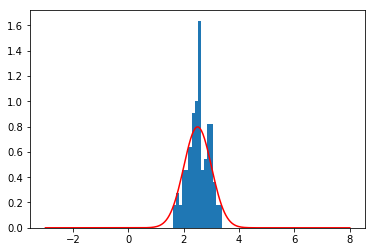

In [59]:
with tf.Session() as sess:
    plt.hist(rejection_samples, range=(-3., 8.), normed=True, bins=100)
    plt.plot(plot_points, sess.run(q.prob(plot_points)), 'r')
    plt.show()